In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np



In [2]:

# Проверка доступности GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [14]:
# Конфигурация
DATA_DIR = '/content/cars'  # Папка с подпапками 'vw_teramont' и 'volvo_xc70'
MODEL_SAVE_PATH = 'car_classifier.pth'
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
IMAGE_SIZE = 224  # ResNet50 ожидает изображения 224x224


In [8]:
!tar -xzvf /content/sample_data/cars.tar.gz

cars/volvo xc70/volx7015.jpg
cars/volvo xc70/Volvo_XC70_212.jpg
cars/vw teramont/1200x900.webp
cars/volvo xc70/volx7013.jpg
cars/vw teramont/GCAAAgDa7OA-960.jpg
cars/vw teramont/dByCoT3VsxuyqekLzy3werSUnNU-1920.jpg
cars/vw teramont/563x304.jpeg
cars/vw teramont/volkswagen-teramont-i-restajling-.16b669d0b7d1a9bcf044c8a89238d2e9.webp
cars/volvo xc70/Volvo_XC70_2F.jpg
cars/vw teramont/cattouchret.webp
cars/vw teramont/WhatsApp Image 2024-11-05 at 14.40.55.jpeg
cars/volvo xc70/241gcas-960.jpg
cars/volvo xc70/volx7020.jpg
cars/vw teramont/WhatsApp Image 2024-11-05 at 14.40.55 (3).jpeg
cars/volvo xc70/eYAAAgBg4OA-1920.jpg
cars/vw teramont/WhatsApp Image 2024-11-05 at 14.40.55 (1).jpeg
cars/vw teramont/volkswagen_teramont-x_2024.jpg
cars/volvo xc70/Volvo_XC70_210.jpg
cars/vw teramont/23091.jpeg
cars/vw teramont/bs6N.webp
cars/volvo xc70/volx7011.jpg
cars/vw teramont/gen240x2_volkswagen_teramont_1204864.jpg
cars/volvo xc70/Volvo-XC70-2-1536x864.jpg
cars/vw teramont/WhatsApp Image 2024-11-05 at

In [9]:
# 1. Подготовка датасета
def prepare_datasets(data_dir):
    # Аугментация данных для тренировочного набора
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Только преобразования для валидационного набора
    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Создание датасетов
    full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

    # Разделение на тренировочный и валидационный наборы (80/20)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    # Применяем валидационные трансформации к валидационному набору
    val_dataset.dataset.transform = val_transforms

    # Создание DataLoader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    return train_loader, val_loader, full_dataset.classes



In [10]:
# 2. Подготовка модели
def prepare_model(num_classes):
    # Загрузка предобученной ResNet50
    model = models.resnet50(pretrained=True)

    # Замораживаем все слои, кроме последнего
    for param in model.parameters():
        param.requires_grad = False

    # Заменяем последний полносвязный слой
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    model = model.to(device)

    return model



In [11]:
# 3. Обучение модели
def train_model(model, train_loader, val_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Тренировочная фаза
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Валидационная фаза
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc.cpu().numpy())

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Сохраняем лучшую модель
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print('Model saved!')

        print()

    # Загружаем лучшую модель
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    # Визуализация процесса обучения
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend()
    plt.title('Loss History')

    plt.subplot(1, 2, 2)
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy History')
    plt.show()

    return model



In [12]:
# 4. Валидация модели
def validate_model(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Матрица ошибок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Отчет классификации
    print(classification_report(all_labels, all_preds, target_names=class_names))



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Classes: ['volvo xc70', 'vw teramont']


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

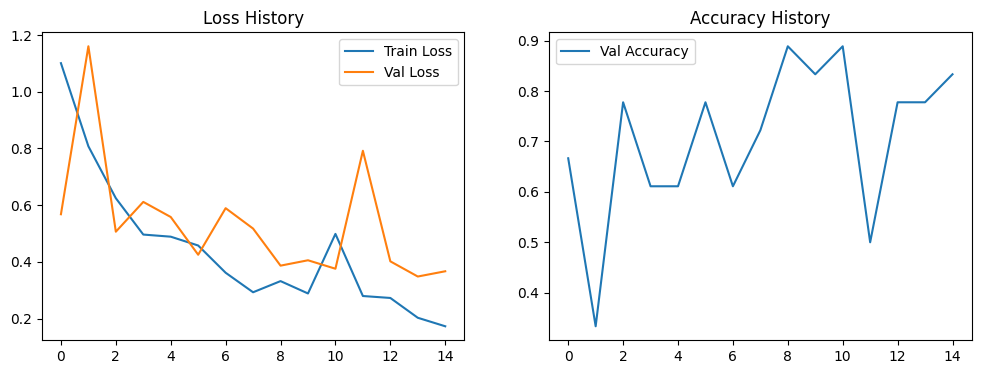

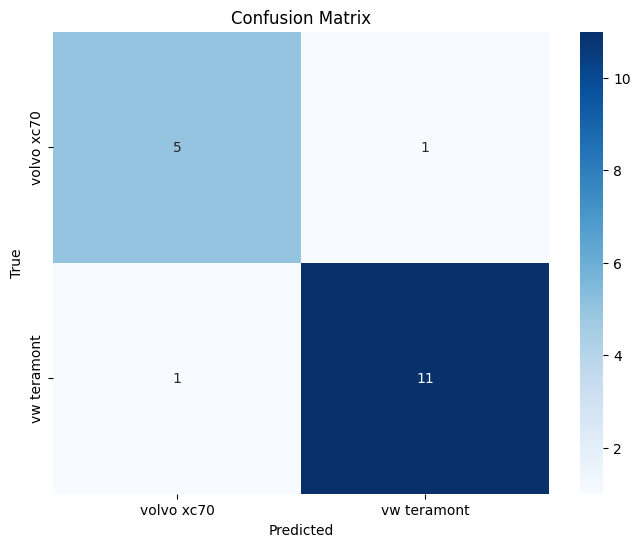

              precision    recall  f1-score   support

  volvo xc70       0.83      0.83      0.83         6
 vw teramont       0.92      0.92      0.92        12

    accuracy                           0.89        18
   macro avg       0.88      0.88      0.88        18
weighted avg       0.89      0.89      0.89        18



In [15]:
# Подготовка данных
train_loader, val_loader, class_names = prepare_datasets(DATA_DIR)
print(f"Classes: {class_names}")

# Подготовка модели
model = prepare_model(len(class_names))
print(model)

# Обучение модели
model = train_model(model, train_loader, val_loader, NUM_EPOCHS)

# Валидация модели
validate_model(model, val_loader, class_names)
